In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter

In [90]:
# generate (un)censored time data
np.random.seed(123)
n = 100
time = np.random.randint(100, size = n)
events = np.random.choice([0,1], size = n)
color_keys = ['blue','orange']

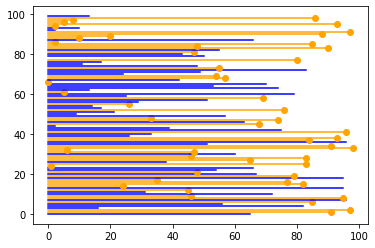

In [91]:
# line plots of censored data
for i in range(len(time)):
    x = np.arange(time[i])
    y = np.repeat(i, time[i])
    plt.plot(x,y, color = color_keys[events[i]])
    if censoring[i]==1:
        plt.plot(np.max(x),i, color=color_keys[events[i]], marker='o')
    
plt.show()

## Survival Functions
- Survival Probability
$$S(t) = \prod_{i=0}^{t} 1-Pr(T=i| T \geq i) = \prod_{i=0}^{t} 1- \frac{d_i}{n_i}$$

- Cummulative hazard
$$\Lambda(t) = \sum_{i=0} \frac{d_i}{n_i}$$

- Hazard
$$\lambda (t) = -\frac{S'(t)}{S(t)}$$

- Equivalences
$$\Lambda(t) = -log S(t)$$
$$S(t) = exp(-\Lambda(t))$$

In [92]:
def compute_survival_functions(events, time):
    idx_time = np.argsort(time) # sort by time
    sorted_censoring = censoring[idx_time]
    sorted_time = time[idx_time]
    cumsum_died = np.cumsum(sorted_censoring)
    cumsum_alive = len(sorted_censoring)-cumsum_died

    # compute survival functions
    cum_hazard = cumsum_died / cumsum_alive
    surv_prob  = np.exp(-cum_hazard)
    
    return {'cum_hazard': cum_hazard, 'surv_prob': surv_prob}

surv_funcs = compute_survival_functions(events, time)

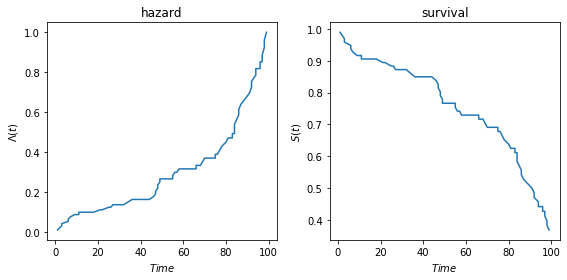

In [93]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(np.sort(time), surv_funcs['cum_hazard'])
plt.title('hazard')
plt.xlabel(r'$Time$')
plt.ylabel(r'$\Lambda(t)$')

plt.subplot(122)
plt.plot(np.sort(time), surv_funcs['surv_prob'])
plt.title('survival')
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')

plt.tight_layout()
plt.show()

In [94]:
# split data into two groups
grouping = np.random.choice(['A','B'], len(time))
timeA, eventsA = time[grouping=='A'], events[grouping=='A'] 
timeB, eventsB = time[grouping=='B'], events[grouping=='B']

# compute survival functions
surv_funcsA = compute_survival_functions(eventsA, timeA)
surv_funcsB = compute_survival_functions(eventsB, timeB)

# Logrank test (or Mantel-Cox test): 
# whether probability of an event at any point is different
lr = logrank_test(durations_A=timeA, durations_B=timeB,
                  event_observed_A=eventsA, event_observed_B=eventsB)
lr.print_summary()

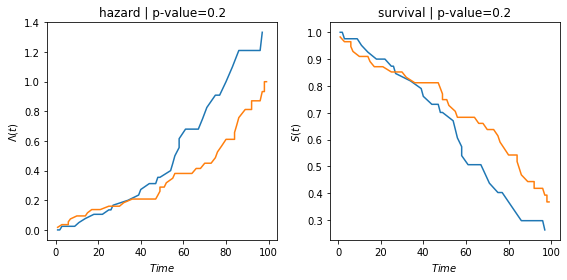

In [102]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.plot(np.sort(timeA), surv_funcsA['cum_hazard'])
plt.plot(np.sort(timeB), surv_funcsB['cum_hazard'])
plt.title('hazard | p-value='+str(np.round(lr.p_value,2)))
plt.xlabel(r'$Time$')
plt.ylabel(r'$\Lambda(t)$')

plt.subplot(122)
plt.plot(np.sort(timeA), surv_funcsA['surv_prob'])
plt.plot(np.sort(timeB), surv_funcsB['surv_prob'])
plt.title('survival | p-value='+str(np.round(lr.p_value,2)))
plt.xlabel(r'$Time$')
plt.ylabel(r'$S(t)$')

plt.tight_layout()
plt.show()

## compute concordance index to make performance assessment of a model

In [100]:
df = pd.DataFrame({'T': time, 'E': events})
cph = CoxPHFitter().fit(df, 'T', 'E')
concordance_index(df['T'], - cph.predict_partial_hazard(df), df['E'])

0.5